# Model: XGBoost Model

## Initialization

In [62]:
%run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import xgboost as xgb

from sklearn.preprocessing import scale

import great_expectations as ge

RANDOM_STATE = 42

from progressbar import ProgressBar
import seaborn as sns

from data.data import (transform_X_numerical, 
                           transform_X_categorical, 
                           transform_X)

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, cross_val_score, cross_validate


For more information on progressbar. Look here https://pypi.org/project/progressbar2/

## Extract Clean Data

**Separate data into X (features) and y (label) from the raw data**

This is exactly what Ben did in his notebook.

In [64]:
Xy = pd.read_csv('../data/processed/train_v2.csv', index_col='passengerid', dtype={'pclass':str})

**List of Features**

In [91]:
important_features = ['title_Mr', 'title_Mrs', 'family_size', 'is_child', 'pclass']
important_features = ['title_Mr', 'pclass_2', 'pclass_3', 'family_size', 'fare', 'age']
#important_features = ['title_Mr',  'pclass_1', 'pclass_2', 'family_size',]

important_features = ['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss', 'title_Officer', 'family_size', 
                      'age_bin_baby', 'fare_bin_q4', 'age_bin_child', 'embarked_S', 'fare_bin_q2']

important_features = ['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss', 'title_Officer', 'family_size', 
                      'age_bin_baby', ]

#important_features = all_columns

In [92]:
X_all = transform_X(Xy.drop(['name', "age", "fare",], axis=1), 
                    numerical_columns=["family_size"],
    categorical_columns=[
        "sex",
        "embarked",
        "title",
        "age_bin",
        "fare_bin",
        "is_child",
        "is_traveling_alone",
        "pclass",
    ], )
X_all.columns = X_all.columns.str.replace(', ','_').str.replace(r'\[|\]|\(|\)','', regex=True)
X_all

X = X_all[important_features].copy()
X.describe()

y = Xy['survived']
X.shape

X.columns

,family_size,is_child,is_traveling_alone,sex_male,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Officer,...,age_bin_child,age_bin_senior,age_bin_student,age_bin_teen,age_bin_young_adult,fare_bin_q2,fare_bin_q3,fare_bin_q4,pclass_2,pclass_3
passengerid,,,,,,,,,,,,,,,,,,,,,
1,0.059160,False,False,1,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0.059160,False,False,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.560975,False,True,0,0,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,1
4,0.059160,False,False,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,-0.560975,False,True,1,0,1,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.560975,False,True,1,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
888,-0.560975,False,True,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
889,1.299429,False,False,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1


,sex_male,title_Mr,pclass_3,title_Mrs,title_Miss,title_Officer,family_size,age_bin_baby
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000
mean,0.647587,0.584736,0.551066,0.142536,0.206510,0.017957,-2.392400e-17,0.053872
std,0.477990,0.493044,0.497665,0.349796,0.405028,0.132871,1.000562e+00,0.225892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.609748e-01,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.609748e-01,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-5.609748e-01,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.915988e-02,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.640372e+00,1.000000


(891, 8)

Index(['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss',
       'title_Officer', 'family_size', 'age_bin_baby'],
      dtype='object')

## Train Test Split Data

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

X_train.describe()
X_test.describe()

xg_cl = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=1000, 
                          seed=123,
                          colsample_bytree=0.3, 
                          learning_rate=0.01, 
                          max_depth=3, 
                          max_features='sqrt',
                          random_state=RANDOM_STATE,
                          subsample=0.2)

xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)

,sex_male,title_Mr,pclass_3,title_Mrs,title_Miss,title_Officer,family_size,age_bin_baby
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.655899,0.591292,0.558989,0.137640,0.203652,0.018258,0.017353,0.057584
std,0.475408,0.491941,0.496857,0.344764,0.402996,0.133979,1.043392,0.233119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.560975,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.560975,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.560975,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.059160,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.640372,1.000000


,sex_male,title_Mr,pclass_3,title_Mrs,title_Miss,title_Officer,family_size,age_bin_baby
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,179.000000
mean,0.614525,0.558659,0.519553,0.162011,0.217877,0.01676,-0.069024,0.039106
std,0.488073,0.497940,0.501019,0.369495,0.413961,0.12873,0.806888,0.194391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.560975,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.560975,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,-0.560975,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.059160,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,3.159833,1.000000


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.2, verbosity=1)

In [94]:
ii_y_pred, ii_predicted_accuracy_score, ii_cv_scores = pm.calc_model_rst_table_metrics(xg_cl, X_train, y_train, X_test, y_test, 
                                                      model_name='xgb_1', cv=5, verbose=True)
    


Accuracy Score on X_test,y_test:  0.8268


Cross Validation Scores:
	Accuracy 	: 0.8230 (+/- 0.0585)
	Recall		: 0.7124 (+/- 0.1359)
	Precision	: 0.7956 (+/- 0.0721)
	F1		: 0.7504 (+/- 0.0995)


11/07/19, xgb_1,  <kaggle_accuracy>, 0.8230, 0.7124,0.7956,0.7504


# Tuning the Model (Best LogReg Model Accuracy = 0.8384)

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [70]:
gbm_param_grid = {'learning_rate': [0.01],
                  'n_estimators': [1000],
                  'subsample': [0.2, 0.3], 
                  'max_depth': [3],
                  'max_features': ['sqrt'],
                  'random_state': [RANDOM_STATE], 
                  'colsample_bytree':[0.3, 0.4, 0.5]}

gsearch = GridSearchCV(estimator=xg_cl,
                       param_grid=gbm_param_grid,
                       scoring='accuracy', cv=4, verbose=1, n_jobs=4)


gsearch.fit(X, y)

print("\n\nBest parameters found: ",gsearch.best_params_)
print("Highest Accuracy: ", gsearch.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    2.5s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.3, gamma=0,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=1000, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_s...,
                                     scale_pos_weight=1, seed=123, silent=None,
                                     subsample=0.2, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5],
                         'learning_rate': [0.01], 'max_depth': [3],
       



Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.3}
Highest Accuracy:  0.8327721661054994


In [71]:
with pd.option_context('display.max_rows', 20):
	pd.DataFrame(gsearch.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.333857,0.422612,0.431081,0.378751,0.420131,0.41269
std_fit_time,0.00490888,0.00444004,0.00553873,0.0023991,0.00423325,0.00221125
mean_score_time,0.00872695,0.0100033,0.00937223,0.0104913,0.00930399,0.0086025
std_score_time,0.000631936,0.000924333,0.0006767,0.000890295,0.000754916,0.000885959
param_colsample_bytree,0.3,0.3,0.4,0.4,0.5,0.5
param_learning_rate,0.01,0.01,0.01,0.01,0.01,0.01
param_max_depth,3,3,3,3,3,3
param_max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
param_n_estimators,1000,1000,1000,1000,1000,1000
param_random_state,42,42,42,42,42,42


# Selecting Important Features

['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss', 'title_Officer', 'family_size', 'age_bin_baby', 'fare_bin_q4', 'age_bin_child', 'embarked_S', 'fare_bin_q2']

Model Report
Accuracy : 0.8384
AUC Score (Train): 0.874272
CV Score : Mean - 0.8674573996265172 | Std - 0.0487875880215876 | Min - 0.7542016806722689 | Max - 0.9401260504201681


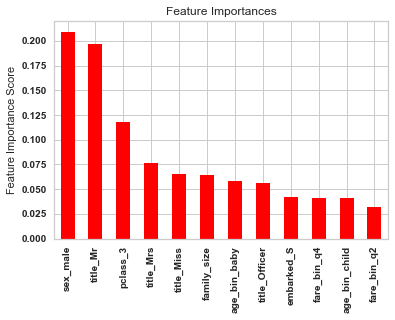

In [72]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=20):
    
    predictors = X.columns.tolist()
    print(predictors)
    
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print(f"CV Score : Mean - {np.mean(cv_score)} | Std - {np.std(cv_score)} | Min - {np.min(cv_score)} | Max - {np.max(cv_score)}")
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

modelfit(xg_cl, X, y)

# Simplify Model

In [73]:
from yellowbrick.features import Rank1D

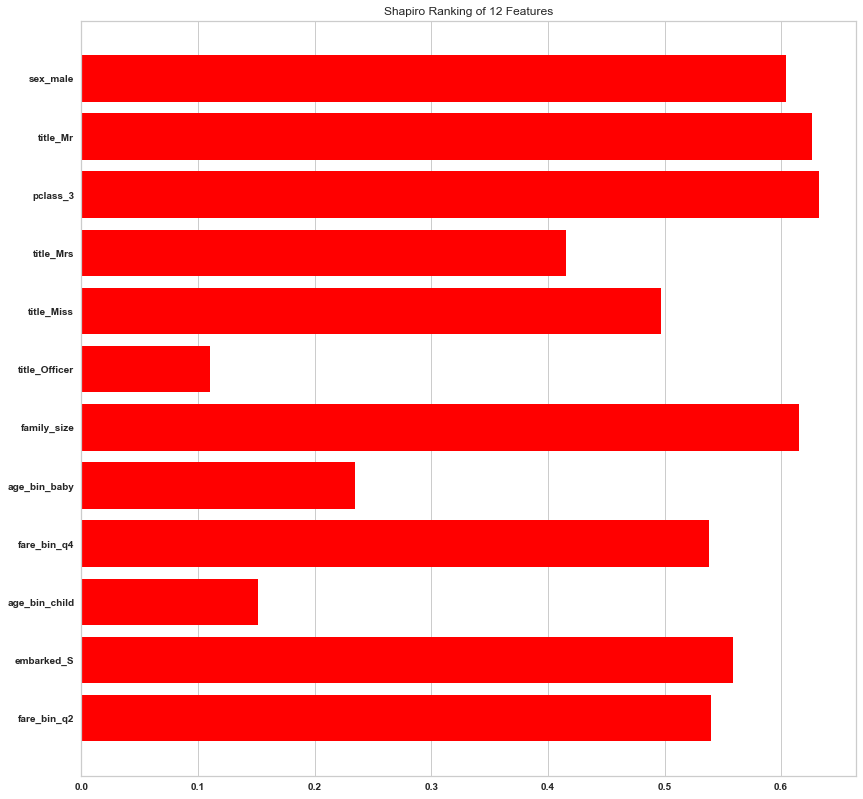

In [74]:
# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro', size=(1000,1000))

visualizer.fit(X, y, )           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show();          # Finalize and render the figure

https://www.districtdatalabs.com/visualize-data-science-pipeline-with-yellowbrick

In [75]:
from cycler import cycler
import matplotlib as mpl
from yellowbrick.model_selection import FeatureImportances

FeatureImportances(absolute=True,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x11b0289b0>,
                   colormap=None, colors=None, is_fitted='auto',
                   labels=Index(['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss',
       'title_Officer', 'family_size', 'age_bin_baby', 'fare_bin_q4',
       'age_bin_child', 'embarked_S', 'fare_bin_q2'],
      dtype='object'),
                   model=None, relative=False, stack=False, xlabel=None)

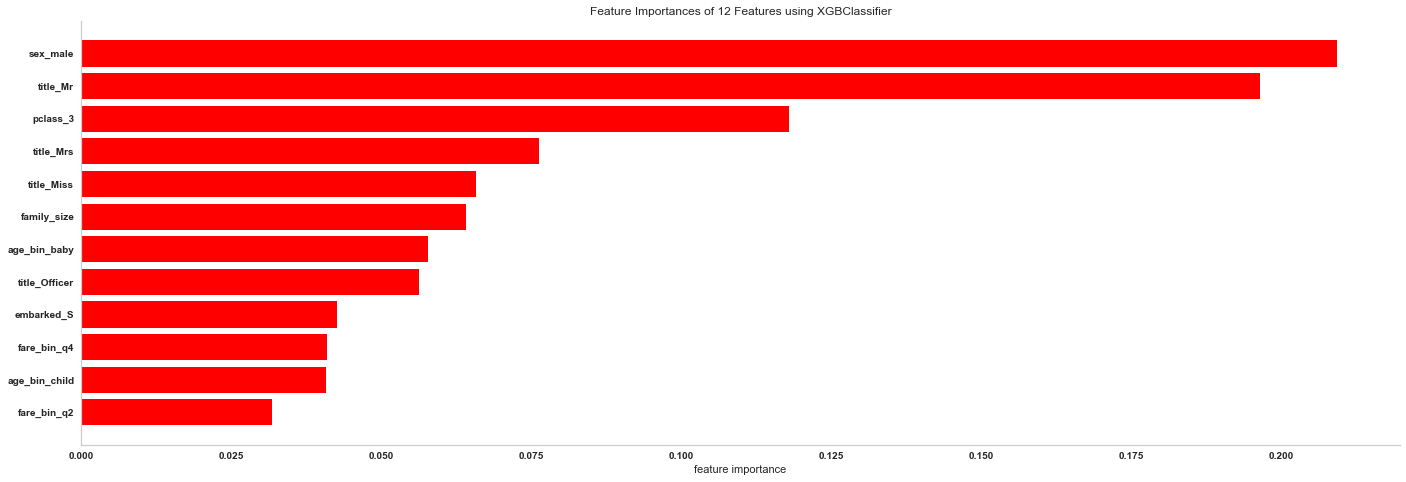

['sex_male',
 'title_Mr',
 'pclass_3',
 'title_Mrs',
 'title_Miss',
 'title_Officer',
 'family_size',
 'age_bin_baby',
 'fare_bin_q4',
 'age_bin_child',
 'embarked_S',
 'fare_bin_q2']

In [76]:
model = xg_cl

# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red'])
fig = plt.gcf()
fig.set_size_inches(20,20)
ax = plt.subplot(311)
labels = X.columns

viz = FeatureImportances(model, ax=ax, labels=labels, relative=False, absolute=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y)
viz.poof();


['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss', 'title_Officer', 'family_size', 'age_bin_baby', 'fare_bin_q4', 'age_bin_child', 'embarked_S', 'fare_bin_q2']

# Prepare Submission

In [77]:
X_holdout = pd.read_csv('../data/processed/holdout_v2.csv', index_col='passengerid', dtype={'pclass':str})
X_holdout.columns

Index(['pclass', 'name', 'sex', 'sibsp', 'parch', 'ticket', 'fare', 'embarked',
       'title', 'last_name', 'cabin_number', 'family_size', 'age_estimate',
       'age', 'age_bin', 'fare_bin', 'is_child', 'is_traveling_alone'],
      dtype='object')

In [78]:
X_test_kaggle_public = transform_X(X_holdout).reindex(X_test.columns, axis=1)
X_test_kaggle_public.columns

X_test_kaggle_public.describe()

Index(['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss',
       'title_Officer', 'family_size', 'age_bin_baby', 'fare_bin_q4',
       'age_bin_child', 'embarked_S', 'fare_bin_q2'],
      dtype='object')

,sex_male,title_Mr,pclass_3,title_Mrs,title_Miss,title_Officer,family_size,age_bin_baby,fare_bin_q4,age_bin_child,embarked_S,fare_bin_q2
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,4.180000e+02,418.000000,0.0,418.000000,418.000000,0.0
mean,0.636364,0.574163,0.521531,0.177033,0.186603,0.011962,-2.974760e-17,0.038278,NaN,0.031100,0.645933,NaN
std,0.481622,0.495062,0.500135,0.382154,0.390059,0.108844,1.001198e+00,0.192095,NaN,0.173797,0.478803,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.534426e-01,0.000000,NaN,0.000000,0.000000,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.534426e-01,0.000000,NaN,0.000000,0.000000,NaN
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-5.534426e-01,0.000000,NaN,0.000000,1.000000,NaN
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.056429e-01,0.000000,NaN,0.000000,1.000000,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.037412e+00,1.000000,NaN,1.000000,1.000000,NaN


In [79]:
y_pred = (pd.Series(xg_cl.predict(X_test_kaggle_public), 
                   index=X_test_kaggle_public.index, name='Survived').to_frame().sort_index()
         )

xg_cl
X_test_kaggle_public.columns

y_pred.index.names = ['PassengerId']
y_pred

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.2, verbosity=1)

Index(['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss',
       'title_Officer', 'family_size', 'age_bin_baby', 'fare_bin_q4',
       'age_bin_child', 'embarked_S', 'fare_bin_q2'],
      dtype='object')

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [80]:
y_submission = (pd.read_csv('../data/raw/gender_submission.csv')
                .set_index('PassengerId')
               )
y_submission

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [81]:
filename = 'xgb_model_3.csv'
y_pred.to_csv(filename)

y_pred_file = (pd.read_csv(filename)
                .set_index('PassengerId')
               )

assert (y_pred_file.index == y_submission.index).all()
assert y_pred_file.index.names == y_submission.index.names
assert (y_pred_file.columns == y_submission.columns).all()

assert (y_pred.index == y_submission.index).all()
assert y_pred.index.names == y_submission.index.names
assert (y_pred.columns == y_submission.columns).all()